
# Classification Tutorial

## Introduction

#### Intel® distribution of OpenVINO™ toolkit overview and terminology

Let us begin with a brief overview of the Intel® Distribution of OpenVINO™ toolkit and what this tutorial will be covering.  The Intel® Distribution of OpenVINO™ toolkit enables the quick deployment of convolutional neural networks (CNN) for heterogeneous execution on Intel® hardware while maximizing performance. This is done using the Intel® Deep Learning Deployment Toolkit (Intel® DLDT) included within the Intel® Distribution of OpenVINO™ toolkit with its main components shown below.

![image alt text](doc/doc_openvino_overview_image.png)

The basic flow is:

1. Use a tool, such as Caffe*, to create and train a CNN inference model

2. Run the created model through Model Optimizer to produce an optimized Intermediate Representation (IR) stored in files (`.bin` and `.xml`) for use with the Inference Engine

3. The User Application then loads and runs models on devices using the Inference Engine and the IR files  

This tutorial will focus on the last step, the User Application and using the Inference Engine to run a model on a CPU.

##### Using the inference engine

Below is a more detailed view of the User Application and Inference Engine:

![image alt text](doc/doc_inference_engine_image.png)

The Inference Engine includes a plugin library for each supported device that has been optimized for the Intel® hardware device CPU, GPU, and VPU.  From here, we will use the terms "device" and “plugin” with the assumption that one infers the other (e.g. CPU device infers the CPU plugin and vice versa).  As part of loading the model, the User Application tells the Inference Engine which device to target which in turn loads the associated plugin library to later run on the associated device. The Inference Engine uses “blobs” for all data exchanges, basically arrays in memory arranged according the input and output data of the model.

###### Inference engine API integration flow

Using the inference engine API follows the basic steps outlined briefly below.  The API objects and functions will be seen later in the sample code.

1. Load the plugin

2. Read the model IR

3. Load the model into the plugin

6. Prepare the input

7. Run inference

8. Process the output

More details on the Inference Engine can be found in the [Inference Engine Development Guide](https://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html)


# Prerequisites

## Create the IR files (Pretrained Model) for the inference model
The Intel® Distribution of OpenVINO™ toolkit includes the [Model Optimizer](http://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) used to convert and optimize trained models into the Intermediate Representation (IR) model files, and the [Inference Engine](http://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html) that uses the IR model files to run inference on hardware devices.  The IR model files can be created from trained models from popular frameworks (e.g. Caffe\*, Tensorflow*, etc.). 
The Intel® Distribution of OpenVINO™ toolkit also includes the [Model Downloader](http://docs.openvinotoolkit.org/latest/_tools_downloader_README.html) utility  to download some common inference models from the [Open Model Zoo](https://github.com/opencv/open_model_zoo). 

Run the following cell to run the Model Downloader utility with the `--print_all` argument to see all the available inference models.

In [1]:
!omz_downloader --name squeezenet1.1 -o raw_model

################|| Downloading squeezenet1.1 ||################

========== Downloading raw_model/public/squeezenet1.1/squeezenet1.1.prototxt
... 100%, 9 KB, 21582 KB/s, 0 seconds passed

========== Downloading raw_model/public/squeezenet1.1/squeezenet1.1.caffemodel
... 100%, 4834 KB, 4674 KB/s, 1 seconds passed

========== Replacing text in raw_model/public/squeezenet1.1/squeezenet1.1.prototxt



Now, use converter.py to converts the models that are not in the Inference Engine IR format into that format using Model Optimizer.

In [2]:
!omz_converter --name squeezenet1.1 -d raw_model -o model

========== Converting squeezenet1.1 to IR (FP16)
Conversion command: /data/venv/openvino_2022.1.0.643/bin/python -- /data/venv/openvino_2022.1.0.643/bin/mo --framework=caffe --data_type=FP16 --output_dir=model/public/squeezenet1.1/FP16 --model_name=squeezenet1.1 --input=data '--mean_values=data[104.0,117.0,123.0]' --output=prob --input_model=raw_model/public/squeezenet1.1/squeezenet1.1.caffemodel --input_proto=raw_model/public/squeezenet1.1/squeezenet1.1.prototxt '--layout=data(NCHW)' '--input_shape=[1, 3, 227, 227]'

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u75443/OpenVINO-dev-cloud-tutorial/raw_model/public/squeezenet1.1/squeezenet1.1.caffemodel
	- Path for generated IR: 	/home/u75443/OpenVINO-dev-cloud-tutorial/model/public/squeezenet1.1/FP16
	- IR output name: 	squeezenet1.1
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	data
	- Output layers: 	prob
	- Input shapes: 	[1, 3, 227, 227]
	- Source layout

# Tutorial Application

## Imports
Module:
- [os](https://docs.python.org/3/library/os.html#module-os) - Operating system specific module (used for file name parsing)
- [cv2](https://docs.opencv.org/trunk/) - OpenCV module
- [time](https://docs.python.org/3/library/time.html#module-time) - time tracking module (used for measuring execution time)
- [numpy](http://www.numpy.org/) - n-dimensional array manipulation, e.g:import numpy as np
- [openvino.inference_engine](https://software.intel.com/en-us/articles/OpenVINO-InferEngine) - the IENetwork and IECore objects e.g: from openvino.inference_engine import IECore
- [matplotlib](https://matplotlib.org/) - pyplot is used for displaying output images e.g: from matplotlib import pyplot as plt

<br><div class=tip><b>Example: </b>
- import os

Run the cell below to import Python dependencies needed for displaying the results in this notebook. 

<br><div class=tip><b>Tip: </b>Select a cell and then use **Ctrl+Enter** to run that cell.</div>

In [3]:
# import the module in this cell
import os 
import cv2
import time
import numpy as np
from openvino.inference_engine import IECore
from matplotlib import pyplot as plt


In [4]:
cv2.__version__

'4.5.5'

## Configuration
Here we will create and set the following configuration parameters
We will set all parameters here only once except for *input_path* which we will change later to point to different images.

In [16]:
# model IR files
# model path: model/public/squeezenet1.1/FP32/ for squeezenet1.1.xml, squeezenet1.1.bin
# Code here
model_xml = "model/public/squeezenet1.1/FP32/squeezenet1.1.xml"
model_bin = "model/public/squeezenet1.1/FP32/squeezenet1.1.bin"

# input image file from path image, here we use dog.jpg
# e.g: images/monkey.jpg
# Code here
input_path = "images/bird.jpg"
   
# CPU extension library to use
cpu_extension_path = os.path.expanduser("~")+"/inference_engine_samples/intel64/Release/lib/libcpu_extension.so"

# device to use
device = "CPU"

# Number of top-n classification results to report, we use 10
# Code here
report_top_n = 10

# output labels - "squeezenet1.1.labels"
#Path to labels mapping file used to map outputted integers to strings (e.g. 7="car")
# Code here
labels_path = "squeezenet1.1.labels"

#print out the value for debug purpose
# Code here 
print("Configuration parameters settings:"
     "\n\tmodel_xml=", model_xml,
      "\n\tmodel_bin=", model_bin,
      "\n\tinput_path=", input_path,
      "\n\tdevice=", device, 
      "\n\tlabels_path=", labels_path, 
      "\n\treport_top_n=", report_top_n)

Configuration parameters settings:
	model_xml= model/public/squeezenet1.1/FP32/squeezenet1.1.xml 
	model_bin= model/public/squeezenet1.1/FP32/squeezenet1.1.bin 
	input_path= images/bird.jpg 
	device= CPU 
	labels_path= squeezenet1.1.labels 
	report_top_n= 10


<b>Expected Output:</b>

<p> Configuration parameters settings:</p>
<p>	model_xml= model/public/squeezenet1.1/FP32/squeezenet1.1.xml </p>
<p>	model_bin= model/public/squeezenet1.1/FP32/squeezenet1.1.bin </p>
<p>	input_path= images/monkey.jpg </p>
<p>	device= CPU </p>
<p>	labels_path= squeezenet1.1.labels </p>
<p>	report_top_n= 10 </p>

## Create network

Here we create an IENetwork object and load the model's IR files into it. After loading the model, we check to make sure that all the model's layers are supported by the plugin we will use. We also check to make sure that the model's input and output are as expected for later when we run inference.

In [17]:
# create Inference Engine instance
ie = IECore()
print("An Inference Engine object has been created")

An Inference Engine object has been created


In [18]:
# load network from IR files
# ie.read_network(model=xml xml, weights=bin file)
# Code here
net = ie.read_network(model=model_xml, weights=model_bin)
print("Loaded model IR files [",model_bin,"] and [", model_xml, "]\n")

# check to make sure that the plugin has support for all layers in the loaded model
supported_layers = ie.query_network(net,device)


# check to make sue that the model's input and output are what is expected
assert len(net.input_info.keys()) == 1, \
    "ERROR: This sample supports only single input topologies"
assert len(net.outputs) == 1, \
    "ERROR: This sample supports only single output topologies"
print("SUCCESS: Model IR files have been loaded and verified")

Loaded model IR files [ model/public/squeezenet1.1/FP32/squeezenet1.1.bin ] and [ model/public/squeezenet1.1/FP32/squeezenet1.1.xml ]

SUCCESS: Model IR files have been loaded and verified


<b>Expected Output:</b>

Loaded model IR files [ model/public/squeezenet1.1/FP32/squeezenet1.1.bin ] and [ model/public/squeezenet1.1/FP32/squeezenet1.1.xml ]

SUCCESS: Model IR files have been loaded and verified

## Load model

Here we load the model network into the plugin so that we may run inference.  `exec_net` will be used later to actually run inference.  After loading, we store the names of the input (`input_blob`) and output (`output_blob`) blobs to use when accessing the input and output blobs of the model.  Lastly, we store the model's input dimensions into the following variables:
- `n` = input batch size
- `c` = number of input channels (here 1 channel per color R,G, and B)
- `h` = input height
- `w` = input width

In [19]:
exec_net = ie.load_network(network=net, num_requests=2, device_name=device)

# store name of input and output blobs
input_blob = next(iter(net.input_info))
output_blob = next(iter(net.outputs))

# read the input's dimensions: n=batch size, c=number of channels, h=height, w=width
# Assign the dimension variables as the object of "net" class
# Code here
n,c,h,w = net.input_info[input_blob].input_data.shape

print("Loaded model into Inference Engine for device:", device, 
      "\nModel input dimensions: n=",n,", c=",c,", h=",h,", w=",w)

Loaded model into Inference Engine for device: CPU 
Model input dimensions: n= 1 , c= 3 , h= 227 , w= 227


<b>Expected Output:</b>

Loaded model into Inference Engine for device: CPU 
Model input dimensions: n= 1 , c= 3 , h= 227 , w= 227

## Load labels

Here, if the `labels_path` variable has been set to point to a label mapping file, we open the file and load the labels into the variable `labels_map`.

In [20]:
labels_map = None
# if labels points to a label mapping file, then load the file into labels_map
print(labels_path)
# os.path.isfile -> check if the input is a file 
if os.path.isfile(labels_path):
    with open(labels_path, 'r') as f:
        # load the mapping data from labels_path to "labels_map"
        # Code here
        labels_map = [x.split(sep=' ', maxsplit=1)[-1].strip() for x in f]
        # for x in f:
            #labels_map.append(x.split(sep=' ', maxsplit=1)[-1].strip())
    print("Loaded label mapping file [",labels_path,"]")
else:
    print("No label mapping file has been loaded, only numbers will be used",
          " for detected object labels")

squeezenet1.1.labels
Loaded label mapping file [ squeezenet1.1.labels ]


Expected Output:

Loaded label mapping file [ squeezenet1.1.labels ]

## Prepare input
 We define the functions `loadInputImage()` and `resizeInputImage()` for the operations so that we may reuse them again later in the tutorial.

In [10]:
# define function to load an input image
def loadInputImage(input_path):
    # globals to store input width and height
    global input_w, input_h
    
    # use OpenCV to load the input image, e.g: cv2.VideoCapture(<string path>)
    # here code 
    cap = cv2.VideoCapture(input_path) 
    
    # store input width and height
    input_w = cap.get(3)
    input_h = cap.get(4)
    print("Loaded input image [",input_path,"], resolution=", input_w, "w x ",
          input_h, "h")

    # load the input image
    ret, image = cap.read()
    del cap
    return image

# define function for resizing input image
#1 ,3,227,227
def resizeInputImage(image):
    # resize image dimensions form image to model's input w x h
    in_frame = cv2.resize(image, (w, h))
    # Change data layout from HWC to CHW
    in_frame = in_frame.transpose((2, 0, 1))  
    # reshape to input dimensions
    in_frame = in_frame.reshape((n, c, h, w))
    print("Resized input image from {} to {}".format(image.shape[:-1], (h, w)))
    return in_frame


Loaded input image [ images/bird.jpg ], resolution= 3264.0 w x  2448.0 h
Resized input image from (2448, 3264) to (227, 227)
Input image:


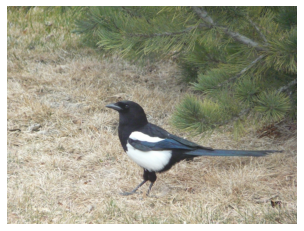

In [21]:
# load image
# load the input_path we defined early, hint: check the name of 
# variable in configuration cell
# Code here
image = loadInputImage(input_path)

# resize the input image
in_frame = resizeInputImage(image)

# display input image
print("Input image:")
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

<b>Expected Output:</b>

Loaded input image [ ./dog.jpg ], resolution= 3124.0 w x  4020.0 h
Resized input image from (4020, 3124) to (227, 227)
<p>Input image:</p>
<img src="doc/dog.jpg" alt="Drawing" style="width: 150px;"/>


# Run inference

Now that we have the input image in the correct format for the model, we now run inference on the input image 

In [22]:
# save start time 
# Question: Why do we need to calculate the time?
inf_start = time.time()

# run inference with the "resized image", do you still remember it?
# Code here
res = exec_net.infer(inputs={input_blob: in_frame})   

# Question: What is "res" behind?

# calculate time from start until now
inf_time = time.time() - inf_start
print("Inference complete, run time: {:.3f} ms".format(inf_time * 1000))

Inference complete, run time: 16.401 ms


## Process and display results

Process the top `report_top_n` items.  We define the function `processAndDisplayResults()` so that we may use it again later in the tutorial to process results.

Top  10  results for image images/bird.jpg :
Probability% is <label>
 0.9974803  is magpie
 0.0014055  is oyster catcher
 0.0003362  is ouzel, dipper
 0.0002929  is mollymawk
 0.0002199  is stork, Ciconia nigra
 0.0000741  is goose
 0.0000670  is drake
 0.0000194  is hornbill
 0.0000120  is turnstone, Arenaria interpres
 0.0000109  is merganser, Mergus serrator


Processed and displayed inference output results.


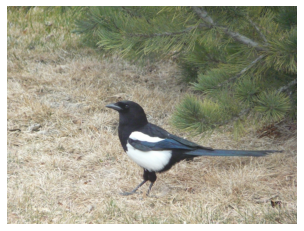

In [24]:
# create function to process inference results
def processAndDisplayResults(probs, orig_input_image, orig_input_path):
    # display image
    plt.figure()
    plt.axis("off")
    im_to_show = cv2.cvtColor(orig_input_image, cv2.COLOR_BGR2RGB)

    # report top n results for image
    print("Top ", report_top_n, " results for image",orig_input_path,":")
    
    # remove dimensions of length=1
    probs = np.squeeze(probs)
    
    # sort then return top report_top_n entries
    top_ind = np.argsort(probs)[-report_top_n:][::-1]
    
    # show input image
    plt.imshow(im_to_show)
    
    # print out top probabilities, looking up label
    print("Probability% is <label>")
    for id in top_ind:
        det_label = labels_map[id] if labels_map else "#{}".format(id)
        print(" {:.7f}  is {}".format(probs[id], det_label))
    print("\n")

processAndDisplayResults(res[output_blob][0], image, input_path)
print("Processed and displayed inference output results.")

<b>Expected Output:</b>

<p> Top  10  results for image ./dog.jpg :</p> 
<p>Probability% is <label></p> 
<p>0.2329701 % is Chihuahua</p> 
<p>0.0853880 % is husky</p> 
<p>0.0783308 % is dog, husky</p> 
<p>0.0472347 % is pug-dog</p> 
 <p>  ...</p> 


## Exercise #1: Run your own image

Now that we have seen all the steps, let us run them again on a different image.  We also define `inferImage()` to combine the input processing, inference, and processing and displaying results so that we may use it again later in the tutorial.

In [ ]:
# define function to prepare input, run inference, and process inference results

# Code here

# prepare input, load?resized? revise the flow from cells above


# run inference


# process inference results 


# set path to different input image
input_path = ?

# load input image
image = ?

# infer image and display results
inferImage(image, input_path)